In this notebook we present comparison of [learning curves](https://en.wikipedia.org/wiki/Learning_curve_(machine_learning)) of best performing models trained in notebook `02. Training ML models`.

This comparison justifies that using more data wont further improve the estimation errors.

In [1]:
# load test dataset
import numpy as np

input_and_output = np.load("../final/dataset.npz")
inputs  = input_and_output["inputs"].astype(np.float64)
outputs = input_and_output["outputs"].astype(np.float64)

dataset_size = inputs.shape[0]
train_size = int(dataset_size * 0.7)
test_size = int(dataset_size * 0.15)

# dropping treatment column in input
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

input_without_treatment = drop_treatment(inputs)
print("dropped treatment column")

LOWER_LIMIT = -7 


def output_transform(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    zeros_in_output = x <= 0
    x[zeros_in_output] = 1
    y = np.log10(x)
    y[zeros_in_output] = LOWER_LIMIT
    y[y < LOWER_LIMIT] = LOWER_LIMIT
    return y
    
def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs < LOWER_LIMIT
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

def apply_size_limit(outputs: np.array) -> np.array:
    x = np.copy(outputs)
    x[x < LOWER_LIMIT] = LOWER_LIMIT
    return x

def apply_absolute_size_limit(outputs: np.array) -> np.array:
    limit = 10 ** LOWER_LIMIT
    x = np.copy(outputs)
    x[x < limit] = 0
    return x

outputs_order_of_magnitude = output_transform(outputs)
print("transformed to orders of magnitude")

from sklearn.decomposition import PCA
import pickle
from pathlib import Path

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

X_train = input_without_treatment[:train_size, :]
Y_train_absolute = apply_absolute_size_limit(outputs[:train_size, :])
X_test = input_without_treatment[train_size:(train_size + test_size), :]
Y_test_absolute = apply_absolute_size_limit(outputs[train_size:(train_size + test_size), :])
Y_train = outputs_order_of_magnitude[:train_size, :]
Y_test = outputs_order_of_magnitude[train_size:(train_size + test_size), :]
Y_train_pca = pca.transform(Y_train)

dropped treatment column
transformed to orders of magnitude


In [2]:
# scaler class

from sklearn.preprocessing import MinMaxScaler


LOGNORMAL_PARAMETERS = (1, 2)
class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res

with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)
    
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [3]:
import time
import psutil
import os
import signal

class TimeoutError(Exception):
    pass

def timeout_handler(*args):
    raise TimeoutError(f"timeout {args}")

def keyboard_interrupt_handler(*args):
    os.kill(os.getpid(), signal.SIGINT)
    
signal.signal(signal.SIGALRM, timeout_handler)

try:
    signal.alarm(2)
    time.sleep(1)
    signal.alarm(0)
    print(f"1. no exception")
except TimeoutError as e:
    print(f"1. message: {e}") 
except KeyboardInterrupt as e:
    print(f"1. KEYBOARD: {e}") 

try:
    signal.alarm(2)
    time.sleep(5)
    signal.alarm(0)
    print(f"2. no exception")
except TimeoutError as e:
    print(f"2. message: {e}")
except KeyboardInterrupt as e:
    print(f"2. keyboard: {e}") 

1. no exception
2. message: timeout (14, <frame at 0x7fb3e50a8630, file '/var/folders/xz/pys3pfc567s9bszzmlt87ytm0000gn/T/ipykernel_36855/1398699701.py', line 29, code <module>>)


In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info

PREFIX_SIZES = [10000, 50000, 100000, 200000, 350000, 500000, 700000]
hidden_layer_sizes = [600, 100, 40]

training_times = []
order_errors = []
asolute_errors = []

for prefix_size in PREFIX_SIZES:
    k = 0
    model_params = {
        "alpha": 0.0040005316095293 / (2 ** k),
        "batch_size": 2000,
        "hidden_layer_sizes": hidden_layer_sizes,
        "learning_rate": "constant",
        "learning_rate_init": 0.00016798744315656234 / (2 ** k),
        "max_iter": 400,
        "n_iter_no_change": 5,
        "random_state": 42,
        "tol": 1e-05 / (2**k),
        "epsilon": 1e-08 / (2**k),
        "verbose": False,
        "warm_start": k > 0
    }
    model = MLPRegressor(**model_params)
    with threadpool_limits(limits=get_cpu_info()["count"], user_api='blas'):
        start_time = time.time()
        model.fit(X_train_scaled[:prefix_size, :], Y_train_pca[:prefix_size, :])
        training_time_s = int(time.time() - start_time)
        training_times.append(training_time_s)
        print(f"trained prefix {prefix_size} in {training_time_s}s")
        
        start_time = time.time()
        test_result_orders   = apply_size_limit(pca.inverse_transform(model.predict(X_test_scaled)))
        test_evaluation_s = int(time.time() - start_time)
        error_test_orders    = mean_squared_error(Y_test,          test_result_orders)
        
        print(f"orders MSE {error_test_orders} calculated in {test_evaluation_s}s")
        
        test_result_absolute = output_untransform(test_result_orders)
        error_test_absolute  = mean_squared_error(Y_test_absolute, test_result_absolute)
        print(f"absolute MSE {error_test_absolute}")
        
        order_errors.append(error_test_orders)
        asolute_errors.append(error_test_absolute)
    

/Users/tpawlowski/workspace/dokstud/lazarou2020/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


trained prefix 10000 in 66s
orders MSE 0.010374770926474021 calculated in 2s
absolute MSE 9.448201147350536e-07


/Users/tpawlowski/workspace/dokstud/lazarou2020/venv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


trained prefix 50000 in 309s
orders MSE 0.0007125744170543182 calculated in 2s
absolute MSE 1.016506503835147e-07
trained prefix 100000 in 467s
orders MSE 0.0002907298214155224 calculated in 2s
absolute MSE 5.2546027537710946e-08
trained prefix 200000 in 802s
orders MSE 0.0001708160967573366 calculated in 3s
absolute MSE 4.014364375597387e-08
trained prefix 350000 in 1800s
orders MSE 0.00010556323800551645 calculated in 7s
absolute MSE 2.268152580090736e-08
trained prefix 500000 in 2980s
orders MSE 9.109505587063872e-05 calculated in 7s
absolute MSE 2.1849173610584956e-08
trained prefix 700000 in 3165s
orders MSE 7.550720517558368e-05 calculated in 7s
absolute MSE 1.5171626028345655e-08


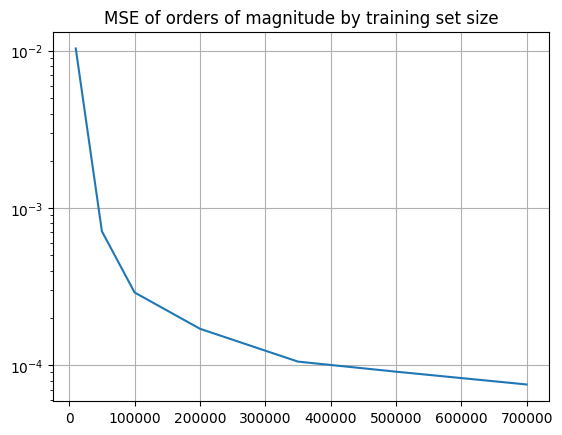

In [9]:
import matplotlib.pyplot as plt

plt.title("MSE of orders of magnitude by training set size")
plt.yscale('log')
plt.grid()
plt.plot(PREFIX_SIZES, order_errors)
plt.show()

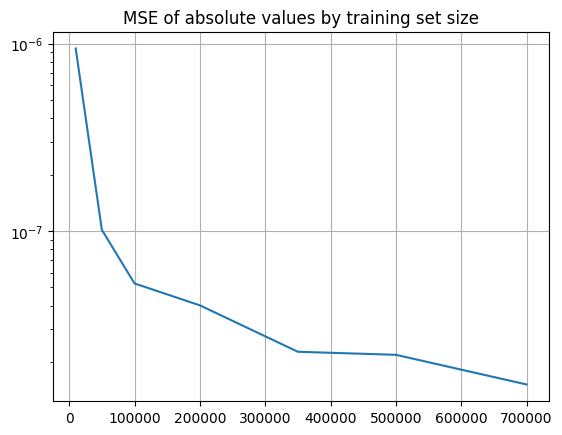

In [6]:
import matplotlib.pyplot as plt

plt.title("MSE of absolute values by training set size")
plt.yscale('log')
plt.grid()
plt.plot(PREFIX_SIZES, asolute_errors)
plt.show()

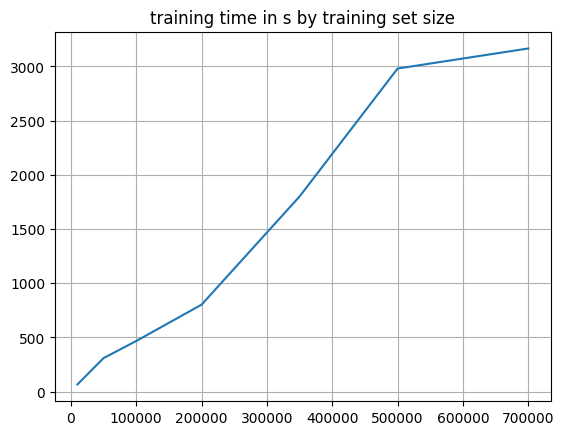

In [7]:
import matplotlib.pyplot as plt

plt.title("training time in s by training set size")
plt.grid()
plt.plot(PREFIX_SIZES, training_times)
plt.show()